In [8]:


import torch
import pandas as pd, psycopg2, os
from sklearn.preprocessing import StandardScaler
import numpy as np  
import torch
from torch.utils.data import Dataset, DataLoader
import joblib
import torch.nn as nn
import datetime as dt
from dotenv import load_dotenv
import matplotlib.pyplot as plt
# --- TensorBoard ---
from torch.utils.tensorboard import SummaryWriter
import time
from BoatRaceDataset import BoatRaceDataset
import itertools

# --- reproducibility helpers ---
import random  # reproducibility helpers

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [2]:


load_dotenv(override=True)

DB_CONF = {
    "host":     os.getenv("PGHOST", "localhost"),
    "port":     int(os.getenv("PGPORT", 5432)),
    "dbname":   os.getenv("PGDATABASE", "boatrace"),
    "user":     os.getenv("PGUSER", "br_user"),
    "password": os.getenv("PGPASSWORD", "secret"),
}

# ------------------------------------------------------------------
# DB 接続
# ------------------------------------------------------------------
conn = psycopg2.connect(**DB_CONF)
df = pd.read_sql("""
    SELECT * FROM feat.train_features
    WHERE race_date <= '2024-12-31'
""", conn)


print(f"Loaded {len(df)} rows from the database.")

# ------------------------------------------------------------------
# Low‑cost performance boost:
# 30‑day rolling stats per racer (starts, win‑rate, etc.)
# ------------------------------------------------------------------
try:
    hist30 = pd.read_sql("SELECT * FROM feat.racer_hist_30d", conn)
    # add lane‑specific suffixes and left‑join for every lane
    for lane in range(1, 7):
        df = df.merge(
            hist30.add_suffix(f"_l{lane}"),            # e.g. starts_30d_l1
            how="left",
            left_on=f"lane{lane}_racer_id",
            right_on=f"racer_id_l{lane}"
        )
    print(f"[info] merged 30‑day stats ‑ new shape: {df.shape}")
except Exception as e:
    # keep pipeline running even if the view is missing
    print("[warn] 30‑day stats merge skipped:", e)

Loaded 2076 rows from the database.
[info] merged 30‑day stats ‑ new shape: (2076, 291)


/var/folders/9n/_65_h0_d791gcmmvjcjjkn9r0000gn/T/ipykernel_83306/768545021.py:15: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql("""
/var/folders/9n/_65_h0_d791gcmmvjcjjkn9r0000gn/T/ipykernel_83306/768545021.py:28: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  hist30 = pd.read_sql("SELECT * FROM feat.racer_hist_30d", conn)


In [3]:


# 風向をラジアンに変換し、sin/cos 特徴量を生成
df["wind_dir_rad"] = np.deg2rad(df["wind_dir_deg"])
df["wind_sin"] = np.sin(df["wind_dir_rad"])
df["wind_cos"] = np.cos(df["wind_dir_rad"])


# numeric columns for StandardScaler
BASE_NUM_COLS = ["air_temp", "wind_speed", "wave_height",
                 "water_temp", "wind_sin", "wind_cos"]
# automatically pick up newly merged rolling features (suffix *_30d)
HIST_NUM_COLS = [c for c in df.columns
                 if c.endswith("_30d") and df[c].dtype != "object"]
NUM_COLS = BASE_NUM_COLS + HIST_NUM_COLS
print(f"[info] StandardScaler will use {len(NUM_COLS)} numeric cols "
      f"({len(BASE_NUM_COLS)} base + {len(HIST_NUM_COLS)} hist)")
scaler = StandardScaler().fit(df[NUM_COLS])
df[NUM_COLS] = scaler.transform(df[NUM_COLS])

bool_cols = [c for c in df.columns if c.endswith("_fs_flag")]
df[bool_cols] = df[bool_cols].fillna(False).astype(bool)

rank_cols = [f"lane{l}_rank" for l in range(1, 7)]
df[rank_cols] = df[rank_cols].fillna(7).astype("int32")
df.to_csv("artifacts/train_features.csv", index=False)
display(df.head())
print("データフレーム全体の欠損値の総数:", df.isnull().sum().sum())

# 各列の欠損値の割合を表示（0〜1の値）
missing_ratio = df.isnull().mean()

# パーセント表示にする場合（見やすさのため）
missing_ratio_percent = missing_ratio * 100

print("各列の欠損値の割合（%）:")
print(missing_ratio_percent.sort_values(ascending=False))

os.makedirs("artifacts", exist_ok=True)
scaler_filename = "artifacts/wind_scaler.pkl"
joblib.dump(scaler, scaler_filename)

/var/folders/9n/_65_h0_d791gcmmvjcjjkn9r0000gn/T/ipykernel_83306/4048372338.py:20: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[bool_cols] = df[bool_cols].fillna(False).astype(bool)


[info] StandardScaler will use 6 numeric cols (6 base + 0 hist)


,race_key,race_date,venue,air_temp,wind_speed,wave_height,water_temp,weather_txt,wind_dir_deg,lane1_racer_id,...,exh_mean_30d_l5,st_mean_30d_l5,racer_id_l6,starts_30d_l6,winrate_30d_l6,exh_mean_30d_l6,st_mean_30d_l6,wind_dir_rad,wind_sin,wind_cos
0,若松_20240101_1,2024-01-01,若松,-1.464009,-1.163734,-1.205108,-1.263955,晴,67.5,5104,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.178097,0.779280,0.288354
1,若松_20240101_10,2024-01-01,若松,-1.338795,-1.163734,-1.205108,-1.263955,晴,67.5,4413,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.178097,0.779280,0.288354
2,若松_20240101_11,2024-01-01,若松,-1.464009,-1.811120,-1.205108,-1.263955,晴,NaN,4155,...,6.94625,0.15125,4958.0,8.0,0.5,6.945000,0.136250,NaN,NaN,NaN
3,若松_20240101_12,2024-01-01,若松,-1.464009,-0.516349,-0.543049,-1.263955,晴,67.5,4349,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.178097,0.779280,0.288354
4,若松_20240101_2,2024-01-01,若松,-1.213581,-1.163734,-1.205108,-1.263955,晴,22.5,5155,...,NaN,NaN,4632.0,7.0,0.0,6.954286,0.235714,0.392699,0.028337,1.278569


データフレーム全体の欠損値の総数: 56432
各列の欠損値の割合（%）:
racer_id_l3         90.751445
st_mean_30d_l3      90.751445
exh_mean_30d_l3     90.751445
winrate_30d_l3      90.751445
starts_30d_l3       90.751445
                      ...    
lane3_loc_starts     0.000000
lane3_motor_no       0.000000
lane3_mot_1st        0.000000
lane3_mot_2nd        0.000000
lane4_2in_natl       0.000000
Length: 294, dtype: float64


['artifacts/wind_scaler.pkl']

In [4]:


def encode(col):
    uniq = sorted(df[col].dropna().unique())
    mapping = {v:i for i,v in enumerate(uniq)}
    df[col + "_id"] = df[col].map(mapping).fillna(-1).astype("int16")
    return mapping
venue2id = encode("venue")
# race_type2id = encode("race_type")

In [5]:


# ============================================================
# 0) ── データの“ラベル & 特徴量”を 1 行だけ覗く可視化 Snippet
#      ★★ ここは notebook なら「1 セルだけ」実行すれば OK ★★
# ------------------------------------------------------------
def peek_one(df: pd.DataFrame, seed: int = 0) -> None:
    """
    ランダムに 1 レース（1 行）だけ抜き取り、順位と主要特徴量を一覧表示
    """
    row = df.sample(1, random_state=seed).squeeze()

    def lane_list(prefix: str):
        return [row[f"lane{i}_{prefix}"] for i in range(1, 7)]

    print("── sample race ──")
    print("rank    :", lane_list("rank"))
    print("exh_time:", lane_list("exh_time"))
    print("st      :", lane_list("st"))
    print("fs_flag :", lane_list("fs_flag"))
    print("weight  :", lane_list("weight"))

# ---------------------------------------------
# ここで一度だけ呼んで目視確認しておくとズレにすぐ気付けます
peek_one(df)
# ============================================================


LANE_DIM = 8
class SimpleCPLNet(nn.Module):
    """
    ctx(6) + boat(4) → lane ごとにスコア 1 個
    """
    def __init__(self, ctx_in=6, boat_in=4, hidden=64, lane_dim=LANE_DIM):
        super().__init__()
        self.lane_emb = nn.Embedding(6, lane_dim)
        self.ctx_fc   = nn.Linear(ctx_in, hidden)
        self.boat_fc  = nn.Linear(boat_in + lane_dim, hidden)
        self.head = nn.Sequential(
            nn.Linear(hidden, hidden),
            nn.ReLU(),
            nn.Linear(hidden, 1)
        )

        # 重み初期化を対称性ブレイク用に Xavier で揃える
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, ctx, boats, lane_ids):  # boats:(B,6,4) lane_ids:(B,6)
        B, L, _ = boats.size()
        ctx_emb  = self.ctx_fc(ctx)           # (B,h)
        # DataLoader から来る lane_ids が (B,) なら (B,6) へブロードキャスト
        # -------- lane_ids の形状を必ず (B,6) にそろえる --------
        if lane_ids.dim() == 1:               # (B,) → (B,6)
            lane_ids = lane_ids.unsqueeze(1).expand(-1, L)
        elif lane_ids.dim() == 2 and lane_ids.size(1) == 1:  # (B,1) → (B,6)
            lane_ids = lane_ids.expand(-1, L)
        # 以外 (既に (B,6)) はそのままで OK
        lane_ids = lane_ids.contiguous()      # Embedding 要求に備え contiguous 化

        lane_emb = self.lane_emb(lane_ids)    # (B,6,lane_dim)
        boat_inp = torch.cat([boats, lane_emb], dim=-1)
        boat_emb = self.boat_fc(boat_inp)     # (B,6,h)

        # broadcast ctx → 各 lane
        score = self.head(torch.tanh(ctx_emb.unsqueeze(1) + boat_emb))  # (B,6,1)
        return score.squeeze(-1)           # (B,6)

── sample race ──
rank    : [np.int32(1), np.int32(3), np.int32(6), np.int32(2), np.int32(5), np.int32(4)]
exh_time: [np.float64(6.93), np.float64(6.94), np.float64(6.95), np.float64(6.93), np.float64(6.95), np.float64(6.89)]
st      : [np.float64(0.12), np.float64(0.19), np.float64(0.16), np.float64(0.08), np.float64(0.1), np.float64(0.07)]
fs_flag : [np.False_, np.False_, np.False_, np.False_, np.False_, np.False_]
weight  : [np.float64(52.9), np.float64(52.3), np.float64(51.0), np.float64(52.0), np.float64(53.2), np.float64(54.5)]


In [6]:


def pl_nll(scores: torch.Tensor, ranks: torch.Tensor) -> torch.Tensor:
    """
    scores : (B, 6) ― lane0 – lane5 のスコア
    ranks  : (B, 6) ― **1 が 1 着, … 6 が 6 着**（列番号ではない）
   """
    scores = scores.clamp(-20.0, 20.0)

    # 着順 (1 → 6) に並んだ lane index を取得
    order = torch.argsort(ranks, dim=1)      # shape (B,6)

    nll = torch.zeros(scores.size(0), device=scores.device)
    s   = scores.clone()
    for pos in range(6):
        log_denom = torch.logsumexp(s, dim=1)            # log Σₗ exp
        idx       = order[:, pos]                        # (B,)
        chosen    = s.gather(1, idx.unsqueeze(1)).squeeze(1)
        nll      += log_denom - chosen
        s         = s.scatter(1, idx.unsqueeze(1), float('-inf'))

    return nll.mean()

# ── pl_nll が正しいか 3 秒で判定 ──
scores = torch.tensor([[6, 5, 4, 3, 2, 1]], dtype=torch.float32)  # lane0 が最強
ranks  = torch.tensor([[1, 2, 3, 4, 5, 6]], dtype=torch.int64)    # lane0 が 1 着
print("pl_nll should be ~0 :", pl_nll(scores, ranks).item())

pl_nll should be ~0 : 2.0691652297973633


In [7]:


df["race_date"] = pd.to_datetime(df["race_date"]).dt.date
latest_date = df["race_date"].max()
cutoff = latest_date - dt.timedelta(days=90)

mode = "zscore"  # "raw", "log", "zscore" も試せる
ds_train = BoatRaceDataset(df[df["race_date"] <  cutoff], mode=mode)
ds_val   = BoatRaceDataset(df[df["race_date"] >= cutoff], mode=mode)
print(f"train: {len(ds_train)}  val: {len(ds_val)}")
# print("train:", ds_train[0])  # 1 レースの特徴量を確認

loader_train = DataLoader(ds_train, batch_size=256, shuffle=True)
loader_val   = DataLoader(ds_val,   batch_size=512)

# ------------------- ⑤ 学習ループ（LR↓ + Clip） --------------
device = "cuda" if torch.cuda.is_available() else "cpu"
model  = SimpleCPLNet().to(device)
opt    = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)

EPOCHS = 20
# --- TensorBoard setup ---
log_dir = os.path.join("artifacts", "tb", time.strftime("%Y%m%d-%H%M%S"))
os.makedirs(log_dir, exist_ok=True)
writer = SummaryWriter(log_dir=log_dir)
for epoch in range(EPOCHS):

    if epoch == 0:                  # 1 エポック目だけ試す例
        ctx, boats, lane_ids, ranks = next(iter(loader_train))
        ctx, boats = ctx.to(device), boats.to(device)
        lane_ids = lane_ids.to(device)

        scores = model(ctx, boats, lane_ids)
        scores.sum().backward()     # ダミー backward
        grad_norm = sum(p.grad.abs().mean().item() for p in model.parameters())
        print(f"[debug] average |grad| = {grad_norm:.3e}")
    # ---- train ----
    model.train(); tr_sum = 0
    for ctx, boats, lane_ids, ranks in loader_train:
        ctx, boats = ctx.to(device), boats.to(device)
        lane_ids, ranks = lane_ids.to(device), ranks.to(device)

        scores = model(ctx, boats, lane_ids)
        pl_loss = pl_nll(scores, ranks)
        pred_rank = scores.argsort(dim=1, descending=True).argsort(dim=1) + 1  # 1〜6 着になるよう変換
        l1_loss = nn.L1Loss()(pred_rank.float(), ranks.float())
        loss = pl_loss + 0.3 * l1_loss  # alpha=0.3 は調整可能
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)  # ★勾配爆発対策★
        opt.step()

        tr_sum += loss.item() * len(ctx)

    tr_nll = tr_sum / len(loader_train.dataset)

    # ---- validation ----
    model.eval(); val_sum = 0
    with torch.no_grad():
        for ctx, boats, lane_ids, ranks in loader_val:
            ctx, boats = ctx.to(device), boats.to(device)
            lane_ids, ranks = lane_ids.to(device), ranks.to(device)
            scores = model(ctx, boats, lane_ids)
            pl_loss = pl_nll(scores, ranks)
            pred_rank = scores.argsort(dim=1, descending=True).argsort(dim=1) + 1
            l1_loss = nn.L1Loss()(pred_rank.float(), ranks.float())
            val_sum += (pl_loss + 0.3 * l1_loss).item() * len(ctx)

    val_nll = val_sum / len(loader_val.dataset)

    print(f"epoch {epoch:2d}  train_nll {tr_nll:.4f}  val_nll {val_nll:.4f}")

    # ---- accuracy & 三連単的中率 ----
    def top1_accuracy(scores, ranks):
        pred_top1 = scores.argmax(dim=1)
        true_top1 = (ranks == 1).nonzero(as_tuple=True)[1]
        return (pred_top1 == true_top1).float().mean().item()

    def trifecta_hit_rate(scores, ranks):
        """
        予測スコア上位3着までと、実際の着順上位3着の組み合わせ一致を見る（順不同）
        """
        pred_top3 = torch.topk(scores, k=3, dim=1).indices
        true_top3 = torch.topk(-ranks, k=3, dim=1).indices  # 小さい順に上位3着
        hit = [set(p.tolist()) == set(t.tolist()) for p, t in zip(pred_top3, true_top3)]
        return sum(hit) / len(hit)

    # accuracy 評価
    model.eval(); all_scores, all_ranks = [], []
    with torch.no_grad():
        for ctx, boats, lane_ids, ranks in loader_val:
            ctx, boats = ctx.to(device), boats.to(device)
            lane_ids = lane_ids.to(device)
            scores = model(ctx, boats, lane_ids).cpu()
            all_scores.append(scores)
            all_ranks.append(ranks)

    all_scores = torch.cat(all_scores, dim=0)
    all_ranks = torch.cat(all_ranks, dim=0)

    acc_top1 = top1_accuracy(all_scores, all_ranks)
    acc_tri3 = trifecta_hit_rate(all_scores, all_ranks)
    writer.add_scalar("loss/train_nll",  tr_nll,  epoch)
    writer.add_scalar("loss/val_nll",    val_nll, epoch)
    writer.add_scalar("acc/top1",        acc_top1, epoch)
    writer.add_scalar("acc/trifecta_hit", acc_tri3, epoch)

    # print(f"Top-1 Acc: {acc_top1:.3f}   Trifecta Hit: {acc_tri3:.3f}")

    # ---- 学習ログを CSV へ追記保存 ----
    import csv
    os.makedirs("artifacts", exist_ok=True)
    log_path = f"artifacts/train_{mode}.csv"
    # 1回目だけヘッダーを書き込む
    write_header = epoch == 0 and not os.path.exists(log_path)
    with open(log_path, mode="a", newline="") as f:
        writer_csv = csv.writer(f)
        if write_header:
            writer_csv.writerow(["epoch", "train_nll", "val_nll", "top1_acc", "trifecta_hit"])
        writer_csv.writerow([epoch, tr_nll, val_nll, acc_top1, acc_tri3])


# --- Close TensorBoard writer after training ---
writer.close()

# ---- Permutation Importance ----
def evaluate_model(model, dataset, device):
    model.eval()
    loader = DataLoader(dataset, batch_size=512)
    total_loss = 0
    with torch.no_grad():
        for ctx, boats, lane_ids, ranks in loader:
            ctx, boats = ctx.to(device), boats.to(device)
            lane_ids, ranks = lane_ids.to(device), ranks.to(device)
            loss = pl_nll(model(ctx, boats, lane_ids), ranks)
            total_loss += loss.item() * len(ctx)
    return total_loss / len(dataset)

def permute_importance(model, dataset, device="cpu", cols=None):
    base_loss = evaluate_model(model, dataset, device)

    importances = {}
    df = dataset.f.copy()

    if cols is None:
        cols = ["wind_speed", "wave_height", "air_temp", "water_temp", "wind_dir_deg"]

    for col in cols:
        shuffled_df = df.copy()
        shuffled_df[col] = np.random.permutation(shuffled_df[col].values)
        temp_ds = BoatRaceDataset(shuffled_df, mode=dataset.mode)
        loss = evaluate_model(model, temp_ds, device)
        importances[col] = loss - base_loss  # 悪化分をスコアとする

    return importances

importance_scores = permute_importance(model, ds_val, device, cols=NUM_COLS)
print("▼ 環境特徴量の重要度（val_nll 増加量）:")
for k, v in sorted(importance_scores.items(), key=lambda x: -x[1]):
    print(f"{k:12s}: {v:.4f}")



train: 1699  val: 377


RuntimeError: mat1 and mat2 shapes cannot be multiplied (1536x14 and 12x64)

In [ ]:


# ---- ROI evaluation on feat.eval_features --------------------------
df_eval = pd.read_sql("SELECT * FROM feat.eval_features", conn)
display(df_eval.head())

/var/folders/9n/_65_h0_d791gcmmvjcjjkn9r0000gn/T/ipykernel_15571/1035810299.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_eval = pd.read_sql("SELECT * FROM feat.eval_features", conn)


,race_key,race_date,venue,air_temp,wind_speed,wave_height,water_temp,weather_txt,wind_dir_deg,lane1_racer_id,...,lane6_boat_2in,lane6_boat_3in,lane6_boa_1st,lane6_boa_2nd,lane6_boa_3rd,lane6_boa_starts,first_lane,second_lane,third_lane,odds
0,若松_20240101_1,2024-01-01,若松,8.0,1.0,1.0,11.0,晴,67.5,5104,...,33.08,48.12,14,30,20,133,1,2,3,12.0
1,若松_20240101_1,2024-01-01,若松,8.0,1.0,1.0,11.0,晴,67.5,5104,...,33.08,48.12,14,30,20,133,1,2,4,31.8
2,若松_20240101_1,2024-01-01,若松,8.0,1.0,1.0,11.0,晴,67.5,5104,...,33.08,48.12,14,30,20,133,1,2,5,15.0
3,若松_20240101_1,2024-01-01,若松,8.0,1.0,1.0,11.0,晴,67.5,5104,...,33.08,48.12,14,30,20,133,1,2,6,65.2
4,若松_20240101_1,2024-01-01,若松,8.0,1.0,1.0,11.0,晴,67.5,5104,...,33.08,48.12,14,30,20,133,1,3,2,9.6


In [ ]:


df_eval = pd.read_sql("SELECT * FROM feat.eval_features WHERE race_date >= '2025-01-01'", conn)
display(df_eval.head())
df_eval.to_csv("artifacts/eval_features.csv", index=False)

/var/folders/9n/_65_h0_d791gcmmvjcjjkn9r0000gn/T/ipykernel_15571/1978071911.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_eval = pd.read_sql("SELECT * FROM feat.eval_features WHERE race_date >= '2025-01-01'", conn)


,race_key,race_date,venue,air_temp,wind_speed,wave_height,water_temp,weather_txt,wind_dir_deg,lane1_racer_id,...,lane6_boat_2in,lane6_boat_3in,lane6_boa_1st,lane6_boa_2nd,lane6_boa_3rd,lane6_boa_starts,first_lane,second_lane,third_lane,odds
0,若松_20250421_1,2025-04-21,若松,17.0,1.0,1.0,20.0,晴,337.5,4234,...,38.33,53.33,37,32,27,180,1,2,3,54.9
1,若松_20250421_1,2025-04-21,若松,17.0,1.0,1.0,20.0,晴,337.5,4234,...,38.33,53.33,37,32,27,180,1,2,4,83.8
2,若松_20250421_1,2025-04-21,若松,17.0,1.0,1.0,20.0,晴,337.5,4234,...,38.33,53.33,37,32,27,180,1,2,5,109.5
3,若松_20250421_1,2025-04-21,若松,17.0,1.0,1.0,20.0,晴,337.5,4234,...,38.33,53.33,37,32,27,180,1,2,6,126.0
4,若松_20250421_1,2025-04-21,若松,17.0,1.0,1.0,20.0,晴,337.5,4234,...,38.33,53.33,37,32,27,180,1,3,2,47.5


In [ ]:


def preprocess_df(df: pd.DataFrame) -> pd.DataFrame:
    """
    Common feature‑engineering pipeline shared by ROI/edge evaluation helpers.

    Parameters
    ----------
    df : pd.DataFrame
        Raw, unprocessed feature matrix fetched from SQL.

    Returns
    -------
    pd.DataFrame
        A *copy* of ``df`` with all feature‑engineering steps applied so that
        downstream routines can mutate it safely.
    """
    df = df.copy()

    # --- polar‑to‑cartesian wind features ---
    df["wind_dir_rad"] = np.deg2rad(df["wind_dir_deg"])
    df["wind_sin"] = np.sin(df["wind_dir_rad"])
    df["wind_cos"] = np.cos(df["wind_dir_rad"])

    # --- numeric scaling (vectorised) ---
    df[NUM_COLS] = scaler.transform(df[NUM_COLS])

    # --- fill boolean & rank columns ---
    bool_cols = [c for c in df.columns if c.endswith("_fs_flag")]
    df[bool_cols] = df[bool_cols].fillna(False).astype(bool)

    rank_cols = [f"lane{l}_rank" for l in range(1, 7)]
    df[rank_cols] = df[rank_cols].fillna(7).astype("int32")

    return df

def evaluate_roi(model, df_eval, device="cpu", mode="zscore", batch_size=512):
    """
    Vectorized ROI & hit-rate for 3-連単。
    Returns (roi, hit_rate, returns_np) where returns_np は
    各レースの払戻額 (的中→odds, 不的中→0) の 1D ndarray
    """
    df = preprocess_df(df_eval)

    ds_eval = BoatRaceDataset(df, mode=mode)
    loader  = DataLoader(ds_eval, batch_size=batch_size, shuffle=False)

    preds_all = []
    model.eval()
    with torch.no_grad():
        for ctx, boats, lane_ids, _ in loader:
                ctx, boats, lane_ids = ctx.to(device), boats.to(device), lane_ids.to(device)
                scores = model(ctx, boats, lane_ids)               # (B,6)
                top3   = scores.argsort(dim=1, descending=True)[:, :3] + 1  # (B,3)
                preds_all.append(top3.cpu().numpy())
    preds = np.vstack(preds_all)                               # (N,3)

    actual = df[["first_lane", "second_lane", "third_lane"]].to_numpy()
    hit_mask = (preds == actual).all(axis=1)
    returns  = np.where(hit_mask, df["odds"].values, 0.0)

    roi       = returns.mean()
    hit_rate  = hit_mask.mean()
    return roi, hit_rate, returns

# ---- 高速固定順位ベースライン -----------------------------------------
def evaluate_roi_fixed(df_eval, pred_order=(1, 2, 3)):
      mask = (
      (df_eval["first_lane"]  == pred_order[0]) &
      (df_eval["second_lane"] == pred_order[1]) &
      (df_eval["third_lane"]  == pred_order[2])
      )
      returns = np.where(mask, df_eval["odds"].values, 0.0)
      return returns.mean(), mask.mean(), returns

# ---- ROI のリスク統計まとめ -------------------------------------------
def evaluate_roi_stats(returns, n_boot=2000, seed=42):
      """
      returns: 1D ndarray (的中オッズ or 0)
      戻り値: dict
      """
      roi = returns.mean()
      std = returns.std(ddof=1)
      se  = std / np.sqrt(len(returns))
      ci_lo, ci_hi = roi - 1.96*se, roi + 1.96*se

      # bootstrap
      rng = np.random.default_rng(seed)
      idx = rng.integers(0, len(returns), size=(n_boot, len(returns)))
      boot_means = returns[idx].mean(axis=1)
      ci_lo_bs, ci_hi_bs = np.percentile(boot_means, [2.5, 97.5])

      sharpe = (roi - 1) / std if std else np.nan   # 1点賭け仮定

      return {
      "roi": roi,
      "std": std,
      "se":  se,
      "ci95_norm": (ci_lo, ci_hi),
      "ci95_boot": (ci_lo_bs, ci_hi_bs),
      "sharpe_like": sharpe,
      }

def evaluate_roi_top_quantile(model, df_eval, device="cpu",
                        quantile=0.2, **kwargs):
      """
      quantile=0.2 → “信頼度上位 20 % のレース” にだけ 1点賭け
      戻り値: dict {roi, hit_rate, coverage, stats}
      """
      # returns_np, conf_np を取得
      _, _, returns, conf = evaluate_roi_with_conf(model, df_eval,
                                                device=device,
                                                return_conf=True,
                                                **kwargs)
      thresh = np.quantile(conf, 1 - quantile)   # 上位 X %
      mask   = conf >= thresh

      returns_sel = returns[mask]
      roi   = returns_sel.mean()
      hit   = (returns_sel > 0).mean()
      cover = mask.mean()            # ← ベット対象レース比率

      stats = evaluate_roi_stats(returns_sel)

      return {"roi": roi, "hit_rate": hit,
            "coverage": cover, **stats}

# ---- ROI ＋ conf　--------------------------------------------
# ------------------------------------------------------------
# ⑧ ── ROI evaluation with edge & Kelly filter
#      「edge ≥ τ かつ kelly > 0」の賭け戦略をオフラインで検証
# ------------------------------------------------------------
def evaluate_roi_edge_filter(model,
                             df_eval: pd.DataFrame,
                             device: str = "cpu",
                             tau: float = 0.25,
                             kelly_clip: float = 1.0,
                             mode: str = "zscore",
                             batch_size: int = 512):
    """
    戻り値: dict {roi, hit_rate, coverage, stats...}
    coverage = 条件を満たすレース比率（≒ ベット対象の割合）
    """
    # (1) edge / kelly を計算
    df_edge = compute_edge_dataframe(model, df_eval,
                                     device=device, mode=mode,
                                     batch_size=batch_size)
    mask = (df_edge["edge"] >= tau) & (df_edge["kelly"] > 0)

    # (2) ベースとなる returns を取得
    _, _, returns = evaluate_roi(model, df_eval,
                                 device=device, mode=mode,
                                 batch_size=batch_size)

    returns_sel = returns[mask.values]
    roi   = returns_sel.mean()
    hit   = (returns_sel > 0).mean()
    cover = mask.mean()

    stats = evaluate_roi_stats(returns_sel)
    return {"roi": roi, "hit_rate": hit,
            "coverage": cover, **stats}

def evaluate_roi_with_conf(model, df_eval, device="cpu",mode="zscore", batch_size=512,return_conf=False):
    """
    returns:
    roi, hit_rate, returns_np[, conf_np]
    * returns_np … 的中時オッズ, 不的中0
    * conf_np     … そのレースの“信頼度”スコア
    """
    df = preprocess_df(df_eval)

    ds_eval = BoatRaceDataset(df, mode=mode)
    loader  = DataLoader(ds_eval, batch_size=batch_size, shuffle=False)

    preds_all, conf_all = [], []
    model.eval()
    with torch.no_grad():
        for ctx, boats, lane_ids, _ in loader:
                ctx, boats, lane_ids = ctx.to(device), boats.to(device), lane_ids.to(device)
                scores = model(ctx, boats, lane_ids)                     # (B,6)

                # ---- ❶ trifecta 予測 -------------------------------
                top3 = scores.argsort(dim=1, descending=True)[:, :3] + 1 # (B,3)
                preds_all.append(top3.cpu().numpy())

                # ---- ❷ “信頼度”指標  ------------------------------
                # ここでは 1着と2着スコア差を採用（大きい=自信あり）
                top2 = scores.topk(2, dim=1).values                      # (B,2)
                conf = (top2[:, 0] - top2[:, 1]).cpu().numpy()           # (B,)
                conf_all.append(conf)

    preds = np.vstack(preds_all)                # (N,3)
    confs = np.concatenate(conf_all)            # (N,)

    actual = df[["first_lane", "second_lane", "third_lane"]].to_numpy()
    hit_mask = (preds == actual).all(axis=1)
    returns  = np.where(hit_mask, df["odds"].values, 0.0)

    roi      = returns.mean()
    hit_rate = hit_mask.mean()

    if return_conf:
        return roi, hit_rate, returns, confs
    else:
        return roi, hit_rate, returns



# # モデル
# roi, hit_rate, ret = evaluate_roi(model, df_eval, device)
# stats = evaluate_roi_stats(ret)

# # ベースライン
# roi_fixed, hit_fixed, ret_fixed = evaluate_roi_fixed(df_eval)
# stats_fixed = evaluate_roi_stats(ret_fixed)

# print("▼ モデル ROI            :",  f"{roi:.3f} (Hit {hit_rate:.3%})")
# print("  - 95%CI norm          :",  f"[{stats['ci95_norm'][0]:.3f}, {stats['ci95_norm'][1]:.3f}]")
# print("  - 95%CI boot          :",  f"[{stats['ci95_boot'][0]:.3f}, {stats['ci95_boot'][1]:.3f}]")
# print("  - σ / SE / Sharpe-like:",  f"{stats['std']:.3f} / {stats['se']:.4f} / {stats['sharpe_like']:.3f}")

# print("▼ 固定1-2-3 ROI         :",  f"{roi_fixed:.3f} (Hit {hit_fixed:.3%})")
# print("  - 95%CI norm          :",  f"[{stats_fixed['ci95_norm'][0]:.3f}, {stats_fixed['ci95_norm'][1]:.3f}]")
# print("   → ROI 差分           :",  f"{roi - roi_fixed:+.3f}")

# # ---- ROI evaluation on feat.eval_features --------------------------
# # (2) 上位 20 % だけ賭ける
# sim20 = evaluate_roi_top_quantile(model, df_eval, device, quantile=0.01)
# print("\n▼ 上位20% ROI :", f"{sim20['roi']:.3f}  Hit {sim20['hit_rate']:.3%}"
#       f"  Coverage {sim20['coverage']:.1%}")
# print("  95%CI :", f"[{sim20['ci95_norm'][0]:.3f}, {sim20['ci95_norm'][1]:.3f}]  "
#       "(norm)")



/var/folders/9n/_65_h0_d791gcmmvjcjjkn9r0000gn/T/ipykernel_15571/2583782344.py:28: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[bool_cols] = df[bool_cols].fillna(False).astype(bool)


edge > 0 ratio : 0.4378987898789879
       first_lane  second_lane  third_lane    odds  p_market   p_model  \
16788           6            3           1  9999.0  0.000075  0.005101   
16781           6            1           3  8917.0  0.000084  0.005101   
18228           6            3           1  8635.0  0.000087  0.005233   
16736           3            6           1  8382.0  0.000089  0.005101   
17864           6            2           1  8857.0  0.000085  0.004823   

            edge     kelly  
16788  50.000131  0.005001  
16781  44.481365  0.004988  
18228  44.182930  0.005117  
16736  41.752585  0.004981  
17864  41.717795  0.004710  

発注リスト (edge ≥ 0.60 & kelly>0): 16269 件
       first_lane  second_lane  third_lane    odds       edge     kelly  \
16788           6            3           1  9999.0  50.000131  0.005001   
16781           6            1           3  8917.0  44.481365  0.004988   
18228           6            3           1  8635.0  44.182930  0.005117   
16736

/var/folders/9n/_65_h0_d791gcmmvjcjjkn9r0000gn/T/ipykernel_15571/2583782344.py:28: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[bool_cols] = df[bool_cols].fillna(False).astype(bool)



▼ edge≥0.60 & kelly>0 ROI : 0.052  Hit 0.025%  Coverage 29.8%
  95%CI norm : [-0.001, 0.104]


/var/folders/9n/_65_h0_d791gcmmvjcjjkn9r0000gn/T/ipykernel_15571/2583782344.py:28: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[bool_cols] = df[bool_cols].fillna(False).astype(bool)



[Equity] 最終累積損益: -3,624 円  累積投下資金: 3,954 円  累積ROI: 0.083


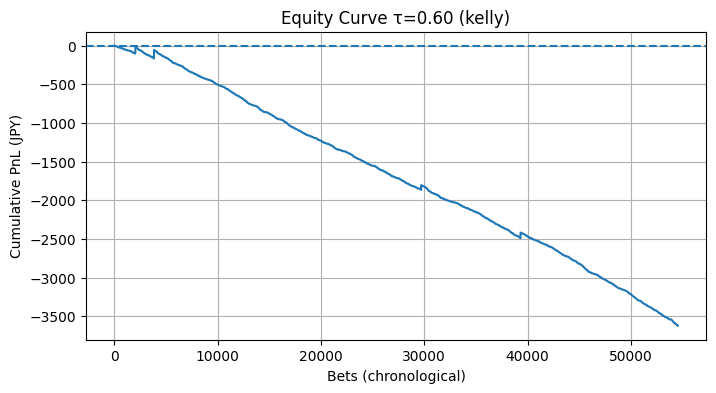

最大ドローダウン: -3,624 円 (nan%)
最長横ばい期間: 54516 bets
[heatmap] required columns 'venue' and 'race_date' not found.


In [ ]:


# ============================================================
# ⑥ ── Market‑vs‑Model “edge” 計算ユーティリティ
#       trifecta のミスプライシングを DataFrame で返す
# ------------------------------------------------------------

def pl_trifecta_prob(scores: torch.Tensor, lanes: tuple[int, int, int]) -> float:
    """
    Plackett‑Luce で lane(0‑based) の組 (a,b,c) が 1‑2‑3 着となる確率を計算する。
    scores : (6,) Tensor
    lanes  : (a,b,c)  0‑based lane index
    """
    s = scores.clone()
    prob = 1.0
    for idx in lanes:
        p = torch.softmax(s, dim=0)[idx]
        prob *= p
        s[idx] = -1e9                     # “抜いた”扱いで次着へ
    return prob.item()


def compute_edge_dataframe(model,
                           df_eval: pd.DataFrame,
                           device: str = "cpu",
                           mode: str = "zscore",
                           batch_size: int = 512,
                           rake: float = 0.25) -> pd.DataFrame:
    """
    各レースの (first_lane,second_lane,third_lane) に対応する
    * 市場確率 p_market
    * モデル確率 p_model
    * edge = odds * p_model − 1
    を計算して返す DataFrame。

    戻り値列:
      [first_lane, second_lane, third_lane, odds, p_market, p_model, edge]
    """
    df = preprocess_df(df_eval)

    # --- prepare lane indices once (0‑based int64, shape (N,3)) ---
    lanes_np = df[["first_lane", "second_lane", "third_lane"]].to_numpy(dtype=np.int64) - 1

    ds_eval = BoatRaceDataset(df, mode=mode)
    loader  = DataLoader(ds_eval, batch_size=batch_size, shuffle=False)

    p_model_list = []
    model.eval()
    row_idx = 0
    with torch.no_grad():
        for ctx, boats, lane_ids, _ in loader:
            ctx, boats, lane_ids = ctx.to(device), boats.to(device), lane_ids.to(device)
            scores = model(ctx, boats, lane_ids)                 # (B,6)
            B = scores.size(0)
            # --- vectorised Plackett‑Luce prob for actual lanes ---
            batch_lanes = torch.from_numpy(lanes_np[row_idx: row_idx + B]).to(device)
            probs = torch.softmax(scores, dim=1)                             # (B,6)
            batch_probs = torch.gather(probs, 1, batch_lanes)               # (B,3)
            p_mod_batch = batch_probs.prod(dim=1).cpu().numpy()             # (B,)
            p_model_list.extend(p_mod_batch.tolist())
            row_idx += B

    # market implied probability (optional rake normalisation)
    p_market = (1.0 / df["odds"]).values           # raw implied
    p_market *= (1.0 - rake)                       # adjust for 25 %控除率

    edge = df["odds"].values * np.array(p_model_list) - 1.0

    df_edge = df[["first_lane", "second_lane", "third_lane", "odds"]].copy()
    df_edge["p_market"] = p_market
    df_edge["p_model"]  = p_model_list
    df_edge["edge"]     = edge
    df_edge["kelly"]    = df_edge["edge"] / df_edge["odds"]
    return df_edge


# ------------------------------------------------------------
# ⑦ ── 発注リスト生成
#      edge ≥ τ かつ kelly > 0 を満たす行のみ抽出
# ------------------------------------------------------------
def make_order_list(df_edge: pd.DataFrame,
                    tau: float = 0.25,
                    kelly_clip: float = 1.0) -> pd.DataFrame:
    """
    Parameters
    ----------
    df_edge : DataFrame returned by `compute_edge_dataframe`
    tau     : edge threshold (default 0.25 ≒ 控除率25 %をカバー)
    kelly_clip : 最大ベット単位数；1.0 で“1 点”上限

    Returns
    -------
    DataFrame with an extra column 'bet_units' (clipped Kelly)
    """
    df = df_edge.copy()
    mask = (df["edge"] >= tau) & (df["kelly"] > 0)
    orders = df.loc[mask].copy()
    orders["bet_units"] = orders["kelly"].clip(0, kelly_clip)
    return orders.sort_values("edge", ascending=False)


# ------------------------------------------------------------
# ⑧b ── 資金曲線（Equity Curve）ユーティリティ
#       edge ≥ τ & kelly>0 の戦略で累積損益を時系列で可視化
# ------------------------------------------------------------
def compute_equity_curve(df_met: pd.DataFrame,
                         tau: float = 0.25,
                         kelly_clip: float = 1.0,
                         bet_mode: str = "kelly",   # "kelly" or "flat"
                         flat_stake: float = 1.0,
                         bet_unit: float = 100.0,
                         sort_cols: tuple = ("race_date", "race_no")) -> pd.DataFrame:
    """
    Parameters
    ----------
    df_met : DataFrame from `compute_metrics_dataframe` (must contain hit, odds, edge, kelly)
    tau    : edge threshold
    kelly_clip : 上限ベット倍率 (units)
    bet_mode   : "kelly" → stake = clip(kelly,0,kelly_clip)
                 "flat"  → stake = flat_stake  (mask条件を満たす行のみ)
    flat_stake : flatモード時の 1ベット単位
    bet_unit   : 1ユニットあたりの金額（円）
    sort_cols  : 時系列並び替えに使う列の候補（存在するものだけ使用）

    Returns
    -------
    DataFrame with追加列:
      bet_units, pnl, cum_pnl, cum_staked, cum_return, cum_roi
      bet_amount, pnl_jpy, return_jpy, cum_pnl_jpy, cum_staked_jpy, cum_return_jpy, cum_roi_jpy
    """
    df = df_met.copy()

    # -- ensure chronological order --
    existing = [c for c in sort_cols if c in df.columns]
    if existing:
        df = df.sort_values(existing).reset_index(drop=True)

    # -- betting mask --
    mask = (df["edge"] >= tau) & (df["kelly"] > 0)

    if bet_mode == "kelly":
        stake = df["kelly"].clip(0, kelly_clip)
    elif bet_mode == "flat":
        stake = np.where(mask, flat_stake, 0.0)
        stake = pd.Series(stake, index=df.index, dtype=float)
    else:
        raise ValueError(f"bet_mode must be 'kelly' or 'flat', got {bet_mode}")

    df["bet_units"] = np.where(mask, stake, 0.0).astype(float)

    # ----- real‑money (JPY) amounts -----
    df["bet_amount"] = df["bet_units"] * bet_unit                     # 円
    profit_if_hit_amt = df["bet_amount"] * (df["odds"] - 1.0)
    df["pnl_jpy"] = np.where(df["hit"], profit_if_hit_amt, -df["bet_amount"])
    df["return_jpy"] = np.where(df["hit"], df["bet_amount"] * df["odds"], 0.0)

    # profit per bet: stake * ((odds - 1) if hit else -1)
    profit_if_hit = (df["odds"] - 1.0)
    df["pnl"] = df["bet_units"] * np.where(df["hit"], profit_if_hit, -1.0)

    # actual returns incl. stake (bet_units*odds on hit, else 0)
    df["return_units"] = df["bet_units"] * np.where(df["hit"], df["odds"], 0.0)
    df["stake_units"]  = df["bet_units"]                               # 1 unit per stake

    # cumulative in units
    df["cum_pnl"]      = df["pnl"].cumsum()
    df["cum_staked"]   = df["stake_units"].cumsum()
    df["cum_return"]   = df["return_units"].cumsum()
    df["cum_roi"]      = np.where(df["cum_staked"] > 0,
                                  df["cum_return"] / df["cum_staked"],
                                  np.nan)
    # cumulative in yen
    df["cum_pnl_jpy"]    = df["pnl_jpy"].cumsum()
    df["cum_staked_jpy"] = df["bet_amount"].cumsum()
    df["cum_return_jpy"] = df["return_jpy"].cumsum()
    df["cum_roi_jpy"]    = np.where(df["cum_staked_jpy"] > 0,
                                    df["cum_return_jpy"] / df["cum_staked_jpy"],
                                    np.nan)
    return df


def plot_equity_curve(df_eq: pd.DataFrame,
                      title: str = "Equity Curve",
                      use_jpy: bool = False,
                      group_by: str = "bets",   # "bets" or "races"
                      figsize=(8, 4)):
    """
    Quick Matplotlib plot of cumulative PnL.

    Parameters
    ----------
    df_eq : pd.DataFrame
        Output of `compute_equity_curve`.
    group_by : {"bets", "races"}
        "bets"  – x‑axis equals individual bets (original behaviour).
        "races" – aggregate PnL per race (race_date × race_no) first,
                  so x‑axis equals number of races.
    use_jpy : bool
        Plot yen‑denominated PnL if True, otherwise unit PnL.
    """
    plt.figure(figsize=figsize)

    if group_by == "races" and {"race_date", "race_no"}.issubset(df_eq.columns):
        # Aggregate per race before cumulative sum
        value_col = "pnl_jpy" if use_jpy else "pnl"
        df_plot = (
            df_eq.groupby(["race_date", "race_no"], as_index=False)[value_col]
                 .sum()
                 .sort_values(["race_date", "race_no"])
        )
        series = df_plot[value_col].cumsum().values
        xlabel = "Races (chronological)"
    else:
        # Original per‑bet cumulative series
        series = (df_eq["cum_pnl_jpy"] if use_jpy else df_eq["cum_pnl"]).values
        xlabel = "Bets (chronological)"

    plt.plot(series)
    plt.axhline(0.0, linestyle="--")
    plt.xlabel(xlabel)
    ylabel = "Cumulative PnL (JPY)" if use_jpy else "Cumulative PnL (units)"
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid(True)
    plt.show()

# ------------------------------------------------------------
# ⑧c ── Risk Metrics & Diagnostics
# ------------------------------------------------------------
def compute_drawdown(df_eq: pd.DataFrame, use_jpy: bool = False) -> tuple:
    """
    Returns (max_drawdown, max_drawdown_pct)
    """
    equity = df_eq["cum_pnl_jpy"] if use_jpy else df_eq["cum_pnl"]
    peak = equity.expanding().max()
    drawdown = equity - peak
    max_dd = drawdown.min()
    max_dd_pct = (max_dd / peak.where(drawdown == max_dd).iloc[0]) if len(equity) else np.nan
    return max_dd, max_dd_pct


def longest_flat_period(df_eq: pd.DataFrame, use_jpy: bool = False) -> int:
    """
    Returns the length (number of bets) of the longest period where equity
    failed to make a new high. (i.e., consecutive drawdown length)
    """
    equity = df_eq["cum_pnl_jpy"] if use_jpy else df_eq["cum_pnl"]
    peak = equity.expanding().max()
    is_dd = equity < peak
    # count consecutive True segments
    counts = (is_dd != is_dd.shift()).cumsum()
    run_lengths = is_dd.groupby(counts).sum()
    return int(run_lengths.max())


def pnl_heatmap(df_met: pd.DataFrame,
                value: str = "pnl_jpy",
                figsize=(10,6),
                bet_unit: float = 100.0):
    """
    Displays a year x venue heatmap of cumulative PnL (JPY).
    """
    if "venue" not in df_met.columns or "race_date" not in df_met.columns:
        print("[heatmap] required columns 'venue' and 'race_date' not found.")
        return

    tmp = df_met.copy()
    tmp["year"] = pd.to_datetime(tmp["race_date"]).dt.year
    tmp["venue"] = tmp.get("venue")  # venue name or id
    pivot = tmp.pivot_table(index="year", columns="venue", values=value, aggfunc="sum").fillna(0)

    plt.figure(figsize=figsize)
    im = plt.imshow(pivot.values, aspect="auto", cmap="RdYlGn")
    plt.colorbar(im, label=f"PnL ({value})")
    plt.xticks(ticks=np.arange(len(pivot.columns)), labels=pivot.columns, rotation=90)
    plt.yticks(ticks=np.arange(len(pivot.index)),  labels=pivot.index)
    plt.title("Year-Venue PnL Heatmap")
    plt.tight_layout()
    plt.show()



# ------------------------------------------------------------
# ⑨ ── SINGLE‑PASS Metrics computation
#      1 回の推論で ROI / conf / edge / kelly を全部まとめて取る
# ------------------------------------------------------------
def compute_metrics_dataframe(model,
                              df_eval: pd.DataFrame,
                              device: str = "cpu",
                              mode: str = "zscore",
                              batch_size: int = 512,
                              rake: float = 0.25) -> pd.DataFrame:
    """
    Returns DataFrame with:
      ['first_lane','second_lane','third_lane','odds',
       'pred1','pred2','pred3','conf',
       'p_model','edge','kelly',
       'hit','returns']
    """
    df = preprocess_df(df_eval)

    # lanes indices & DataLoader
    lanes_np = df[["first_lane", "second_lane", "third_lane"]].to_numpy(dtype=np.int64) - 1
    ds_eval  = BoatRaceDataset(df, mode=mode)
    loader   = DataLoader(ds_eval, batch_size=batch_size, shuffle=False)

    preds_all, conf_all, p_model_list = [], [], []
    model.eval(); row_idx = 0
    with torch.no_grad():
        for ctx, boats, lane_ids, _ in loader:
            ctx, boats, lane_ids = ctx.to(device), boats.to(device), lane_ids.to(device)
            scores   = model(ctx, boats, lane_ids)                   # (B,6)
            B        = scores.size(0)
            # --- predictions & confidence (top‑3 & diff top1‑top2) ---
            top3 = scores.argsort(dim=1, descending=True)[:, :3] + 1  # (B,3)
            preds_all.append(top3.cpu().numpy())

            top2_vals = scores.topk(2, dim=1).values
            conf_batch = (top2_vals[:, 0] - top2_vals[:, 1]).cpu().numpy()
            conf_all.append(conf_batch)

            # --- p_model for actual lanes (vectorised PL) ------------
            batch_lanes = torch.from_numpy(lanes_np[row_idx: row_idx + B]).to(device)
            probs = torch.softmax(scores, dim=1)
            p_mod_batch = torch.gather(probs, 1, batch_lanes).prod(dim=1).cpu().numpy()
            p_model_list.extend(p_mod_batch.tolist())

            row_idx += B

    preds = np.vstack(preds_all)                 # (N,3)
    confs = np.concatenate(conf_all)             # (N,)

    # ---------- market / edge ----------
    p_market = (1.0 / df["odds"]).values
    p_market *= (1.0 - rake)
    edge  = df["odds"].values * np.array(p_model_list) - 1.0
    kelly = edge / df["odds"].values

    # ---------- hit / returns ----------
    actual   = df[["first_lane", "second_lane", "third_lane"]].to_numpy()
    hit_mask = (preds == actual).all(axis=1)
    returns  = np.where(hit_mask, df["odds"].values, 0.0)

    # ---------- assemble ----------
    df_met = df[["race_key", "first_lane", "second_lane", "third_lane", "odds"]].copy()
    df_met[["pred1","pred2","pred3"]] = preds
    df_met["conf"]    = confs
    df_met["p_model"] = p_model_list
    df_met["edge"]    = edge
    df_met["kelly"]   = kelly
    df_met["hit"]     = hit_mask
    df_met["returns"] = returns
    return df_met


def evaluate_roi_edge_filter_fast(model,
                                  df_eval: pd.DataFrame,
                                  device: str = "cpu",
                                  tau: float = 0.25,
                                  kelly_clip: float = 1.0,
                                  mode: str = "zscore",
                                  batch_size: int = 512):
    """
    Single‑pass版 edge フィルター ROI 評価
    """
    df_met = compute_metrics_dataframe(model, df_eval, device,
                                       mode=mode, batch_size=batch_size)
    mask = (df_met["edge"] >= tau) & (df_met["kelly"] > 0)
    returns_sel = df_met.loc[mask, "returns"].values
    roi   = returns_sel.mean()
    hit   = (returns_sel > 0).mean()
    cover = mask.mean()

    stats = evaluate_roi_stats(returns_sel)
    return {"roi": roi, "hit_rate": hit, "coverage": cover, **stats}

# --- Usage Example ---
# --- Example: edge distribution on evaluation set ---
df_edge = compute_edge_dataframe(model, df_eval, device=device)
print("edge > 0 ratio :", (df_edge["edge"] > 0).mean())
print(df_edge.sort_values("edge", ascending=False).head())

# --- Build order list ---
tau = 0.6
order_df = make_order_list(df_edge, tau)
print(f"\n発注リスト (edge ≥ {tau:.2f} & kelly>0): {len(order_df)} 件")
print(order_df[["first_lane","second_lane","third_lane","odds","edge","kelly","bet_units"]]
        .head())

# (3) edge & Kelly フィルター戦略のオフライン評価
sim_edge = evaluate_roi_edge_filter_fast(model, df_eval, device,
                                            tau=tau, kelly_clip=1.0)
print(f"\n▼ edge≥{tau:.2f} & kelly>0 ROI : {sim_edge['roi']:.3f}"
        f"  Hit {sim_edge['hit_rate']:.3%}"
        f"  Coverage {sim_edge['coverage']:.1%}")
print("  95%CI norm :", f"[{sim_edge['ci95_norm'][0]:.3f}, {sim_edge['ci95_norm'][1]:.3f}]")

# --- Build metrics DF once & plot equity curve ----------------------
df_met = compute_metrics_dataframe(model, df_eval, device=device, batch_size=512)
df_eq  = compute_equity_curve(df_met, tau=tau, kelly_clip=1.0, bet_mode="kelly")
print(f"\n[Equity] 最終累積損益: {df_eq['cum_pnl_jpy'].iloc[-1]:,.0f} 円  "
      f"累積投下資金: {df_eq['cum_staked_jpy'].iloc[-1]:,.0f} 円  "
      f"累積ROI: {df_eq['cum_roi_jpy'].iloc[-1]:.3f}")
plot_equity_curve(df_eq, title=f'Equity Curve τ={tau:.2f} (kelly)', use_jpy=True)

# --- Risk diagnostics ------------------------------------------------
max_dd, max_dd_pct = compute_drawdown(df_eq, use_jpy=True)
flat_len = longest_flat_period(df_eq, use_jpy=True)
print(f"最大ドローダウン: {max_dd:,.0f} 円 ({max_dd_pct:.2%})")
print(f"最長横ばい期間: {flat_len} bets")

# --- Year-Venue heatmap ---------------------------------------------
pnl_heatmap(df_met.assign(pnl_jpy=df_eq['pnl_jpy']), value="pnl_jpy")

In [ ]:


# ============================================================
# ④ ── 「勾配が流れているか」を瞬時に確認する Snippet
#       （エポック終了後 1 回だけ走らせれば十分）
# ------------------------------------------------------------

# ============================================================
 
 # ============================================================
 # ⑤ ── 超小規模データで「過学習できるか」テスト関数
 #       必要時に呼び出して 0.1 以下まで loss が落ちるか確認
 # ------------------------------------------------------------
def overfit_tiny(df: pd.DataFrame, device: str = "cpu"):
    """
    データセットを 10 行だけに縮小し、500 step で過学習できるか検証
    """
    tiny_df = df.sample(10, random_state=1).reset_index(drop=True)
    tiny_ds = BoatRaceDataset(tiny_df, mode=mode)
    tiny_loader = DataLoader(tiny_ds, batch_size=10, shuffle=True)

    net = SimpleCPLNet().to(device)
    opt = torch.optim.AdamW(net.parameters(), lr=3e-3)

    for _ in range(500):
        ctx, boats, lane_ids, ranks = next(iter(tiny_loader))
        ctx, boats = ctx.to(device), boats.to(device)
        lane_ids, ranks = lane_ids.to(device), ranks.to(device)

        loss = pl_nll(net(ctx, boats, lane_ids), ranks)
        opt.zero_grad(); loss.backward(); opt.step()

    print("[tiny] final loss:", loss.item())


# ---- tiny データで特徴量の分散を確認 -----------------------
tiny_df = df.sample(10, random_state=1).reset_index(drop=True)
num_cols = tiny_df.select_dtypes(include="number").columns

# (1) 行間（=レース間）での分散
print("► 行間 variance (should be >0):")
print(tiny_df[num_cols].var().nsmallest(10))

# (2) 同一レース内（= 6 艇間）での分散
def per_race_var(col):
    return tiny_df.groupby("race_key")[col].var().mean()

per_race = {c: per_race_var(c) for c in num_cols}
print("\n► 6 艇間 variance:")
print(sorted(per_race.items(), key=lambda x: x[1])[:10])

# ---- 呼び方例 ----
overfit_tiny(df, device)
# ============================================================

► 行間 variance (should be >0):
lane1_l_now       0.000000
lane2_f_now       0.000000
lane2_l_now       0.000000
lane3_f_now       0.000000
lane3_l_now       0.000000
lane4_l_now       0.000000
lane5_l_now       0.000000
lane6_l_now       0.000000
venue_id          0.000000
st_mean_30d_l1    0.000401
dtype: float64

► 6 艇間 variance:
[('air_temp', nan), ('wind_speed', nan), ('wave_height', nan), ('water_temp', nan), ('wind_dir_deg', nan), ('lane1_racer_id', nan), ('lane1_weight', nan), ('lane1_exh_time', nan), ('lane1_st', nan), ('lane1_rank', nan)]
[tiny] final loss: 0.0045974375680089


In [ ]:


torch.save({
    "state_dict": model.state_dict(),
    "scaler": scaler_filename,
    "venue2id": venue2id,
    # "race_type2id": race_type2id
}, "cplnet_checkpoint.pt")

In [ ]:


import nbformat
from nbconvert import PythonExporter

with open("main.ipynb", "r", encoding="utf-8") as f:
    nb = nbformat.read(f, as_version=4)

exporter = PythonExporter()
source, _ = exporter.from_notebook_node(nb)

with open("main.py", "w", encoding="utf-8") as f:
    f.write(source)

/var/folders/9n/_65_h0_d791gcmmvjcjjkn9r0000gn/T/ipykernel_15571/2304234358.py:141: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_recent = pd.read_sql(query, conn)


[simulate] Loaded 1440 rows (2025-07-17 – 2025-07-21).
[simulate] ROI (edge≥0.60): 0.000  | Profit: -131円 | Stake: 131円 | Bets: 1440
[simulate] Max DD: -131円 | Longest flat: 1439 bets


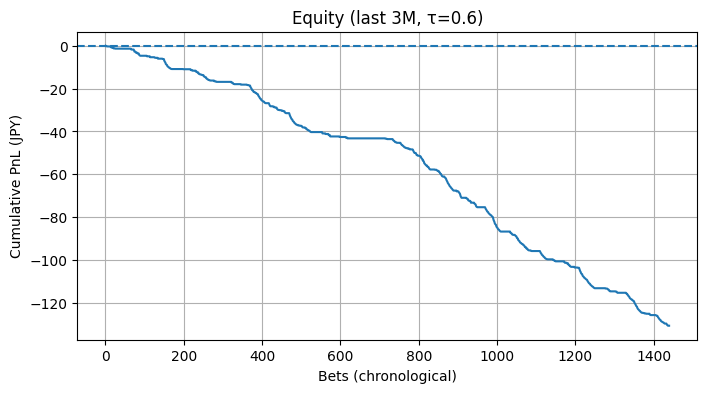

[heatmap] required columns 'venue' and 'race_date' not found.


In [ ]:


# ============================================================
# ★ 予測用スクリプト（直近3ヶ月データを使って予測） ★
# ============================================================

def run_experiment(data_frac, df_full, mode="zscore", epochs=5, device="cpu"):
    df_frac = df_full.sample(frac=data_frac, random_state=42)
    df_frac["race_date"] = pd.to_datetime(df_frac["race_date"]).dt.date
    latest_date = df_frac["race_date"].max()
    cutoff = latest_date - dt.timedelta(days=90)  # last 3 months used as validation set
    ds_train = BoatRaceDataset(df_frac[df_frac["race_date"] < cutoff], mode=mode)
    ds_val = BoatRaceDataset(df_frac[df_frac["race_date"] >= cutoff], mode=mode)

    loader_train = DataLoader(ds_train, batch_size=256, shuffle=True)
    loader_val = DataLoader(ds_val, batch_size=512)

    model = SimpleCPLNet().to(device)
    opt = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)

    for epoch in range(epochs):
        model.train()
        for ctx, boats, lane_ids, ranks in loader_train:
            ctx, boats = ctx.to(device), boats.to(device)
            lane_ids, ranks = lane_ids.to(device), ranks.to(device)
            loss = pl_nll(model(ctx, boats, lane_ids), ranks)
            opt.zero_grad(); loss.backward(); opt.step()

    train_loss = evaluate_model(model, ds_train, device)
    val_loss = evaluate_model(model, ds_val, device)
    return train_loss, val_loss

# 学習曲線の描画
def plot_learning_curve(df, device):
    data_fracs = [0.01, 0.05, 0.1, 0.2, 0.5, 1.0]
    results = []

    for frac in data_fracs:
        tr_loss, val_loss = run_experiment(frac, df, device=device)
        print(f"Data frac {frac:.2f} → Train: {tr_loss:.4f} / Val: {val_loss:.4f}")
        results.append((frac, tr_loss, val_loss))

    fracs, tr_losses, val_losses = zip(*results)
    plt.plot(fracs, tr_losses, label="Train Loss")
    plt.plot(fracs, val_losses, label="Val Loss")
    plt.xlabel("Training Data Fraction")
    plt.ylabel("Loss")
    plt.title("Learning Curve")
    plt.legend()
    plt.grid(True)
    plt.show()

def predict_latest_3months():
    import datetime as dt
    today = dt.date.today()
    three_months_ago = today - dt.timedelta(days=90)

    query = f"""
        SELECT * FROM feat.train_features
        WHERE race_date BETWEEN '{three_months_ago}' AND '{today}'
    """
    df_pred = pd.read_sql(query, conn)
    print(f"[predict] Loaded {len(df_pred)} rows for prediction")

    # --- 前処理 ---
    df_pred["wind_dir_rad"] = np.deg2rad(df_pred["wind_dir_deg"])
    df_pred["wind_sin"] = np.sin(df_pred["wind_dir_rad"])
    df_pred["wind_cos"] = np.cos(df_pred["wind_dir_rad"])
    df_pred[NUM_COLS] = scaler.transform(df_pred[NUM_COLS])

    bool_cols = [c for c in df_pred.columns if c.endswith("_fs_flag")]
    df_pred[bool_cols] = df_pred[bool_cols].fillna(False)
    rank_cols = [f"lane{l}_rank" for l in range(1, 7)]
    df_pred[rank_cols] = df_pred[rank_cols].fillna(7).astype("int32")

    pred_ds = BoatRaceDataset(df_pred, mode="zscore")
    pred_loader = DataLoader(pred_ds, batch_size=1)

    model.eval()
    for i, (ctx, boats, lane_ids, _) in enumerate(pred_loader):
        ctx, boats, lane_ids = ctx.to(device), boats.to(device), lane_ids.to(device)
        with torch.no_grad():
            scores = model(ctx, boats, lane_ids)  # (1,6)
            pred_rank = scores.squeeze().argsort(descending=True).argsort() + 1
            # print(f"[{i:03d}] 予測順位:", pred_rank.cpu().numpy())

    # --- 追加: 固定着順との比較評価 ---
    def evaluate_against_fixed_ranks(pred_loader):
        """
        着順 [1,2,3,4,5,6] を常に予測したと仮定した場合と、モデルの予測を比較する
        """
        model_correct = [0] * 6
        fixed_correct = [0] * 6
        total = 0

        model.eval()
        for _, (ctx, boats, lane_ids, true_ranks) in enumerate(pred_loader):
            ctx, boats, lane_ids = ctx.to(device), boats.to(device), lane_ids.to(device)
            true_ranks = true_ranks.to(device)

            with torch.no_grad():
                scores = model(ctx, boats, lane_ids)
                pred_rank = scores.squeeze().argsort(descending=True).argsort() + 1  # (6,)

            total += 1
            for i in range(6):
                # モデルがその艇の着順を当てたか
                if pred_rank[i].item() == true_ranks[0][i].item():
                    model_correct[i] += 1
                # 固定予測 [1,2,3,4,5,6] を使った場合
                if (i + 1) == true_ranks[0][i].item():
                    fixed_correct[i] += 1

        print("\n--- モデル vs 固定着順 予測精度 ---")
        for i in range(6):
            print(f"{i+1}着: モデル={model_correct[i]/total:.3f}  固定={fixed_correct[i]/total:.3f}  (正解数: モデル={model_correct[i]} 固定={fixed_correct[i]})")

    evaluate_against_fixed_ranks(pred_loader)

# 呼び出し例

# plot_learning_curve(df, device)
# predict_latest_3months()

# ============================================================
# ★ 直近3ヶ月データで実ベットシミュレーション ★
# ============================================================
def simulate_last_3months(tau: float = 0.60,
                          kelly_clip: float = 1.0,
                          bet_unit: float = 100.0,
                          device: str = "cpu"):
    """
    Fetch last 90‑day races, compute edge & Kelly strategy,
    and output ROI / PnL statistics + equity curve.
    """
    today = dt.date.today()
    start_date = today - dt.timedelta(days=4)

    query = f"""
        SELECT * FROM feat.eval_features
        WHERE race_date BETWEEN '{start_date}' AND '{today}'
    """
    df_recent = pd.read_sql(query, conn)
    if df_recent.empty:
        print("[simulate] No rows fetched for last 3 months.")
        return

    print(f"[simulate] Loaded {len(df_recent)} rows ({start_date} – {today}).")

    # ----- metrics & equity -----
    df_met = compute_metrics_dataframe(model, df_recent,
                                       device=device, batch_size=512)
    df_eq  = compute_equity_curve(df_met, tau=tau, kelly_clip=kelly_clip,
                                  bet_unit=bet_unit, bet_mode="kelly")
    
    df_met.to_csv("metrics_last_3months.csv", index=False)
    df_eq.to_csv("equity_curve_last_3months.csv", index=False)
    df_eq[df_eq["bet_units"] > 0][["race_key", "first_lane", "second_lane", "third_lane", "odds", "bet_units"]].to_csv("bet_orders_last_3months.csv", index=False)
    df_eq[(df_eq["bet_units"] > 0) & (df_eq["hit"] == True)][
        ["race_key", "first_lane", "second_lane", "third_lane", "odds", "bet_units", "pnl_jpy"]
    ].to_csv("hit_bets_last_3months.csv", index=False)
    print(f"[simulate] ROI (edge≥{tau:.2f}): {df_eq['cum_roi_jpy'].iloc[-1]:.3f} "
          f" | Profit: {df_eq['cum_pnl_jpy'].iloc[-1]:,.0f}円 "
          f"| Stake: {df_eq['cum_staked_jpy'].iloc[-1]:,.0f}円 "
          f"| Bets: {len(df_eq)}")

    max_dd, _ = compute_drawdown(df_eq, use_jpy=True)
    flat_len = longest_flat_period(df_eq, use_jpy=True)
    print(f"[simulate] Max DD: {max_dd:,.0f}円 | Longest flat: {flat_len} bets")

    plot_equity_curve(df_eq,
                      title=f'Equity (last 3M, τ={tau})',
                      use_jpy=True,
                      group_by="races")
    pnl_heatmap(df_met.assign(pnl_jpy=df_eq["pnl_jpy"]), value="pnl_jpy")

# Optional direct run
simulate_last_3months(tau=0.60, kelly_clip=1.0, device=device)